#CISC684 - Final Project: Hotel Review Sentiment Analysis
###Jacob Meredith, Yaren Usul, Connor Ludwin, Madison Johnson

In [ ]:
pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 13.0 MB/s eta 0:00:00


In [ ]:
# Import all necessary libraries for RNN, datacleaning, and other tasks

# Data import & RNN libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from sklearn.metrics import mean_squared_error
import os
from google.colab import drive

# Data sorting & cleaning libraries
import nltk
from nltk.corpus import wordnet
import string
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('no')
stop_words.discard('not')
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True) #if having endpt not connected error, this forces Google Drive to remount, which refreshes the connection
# Read a CSV file from the shared drive
reviews_df = pd.read_csv('/content/drive/Shared drives/CISC684 - Machine Learning/Hotel_Reviews.csv')
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + " " + reviews_df["Positive_Review"]
# create the label
reviews_df["review_score"] = (reviews_df["Reviewer_Score"]).astype(float)
# select only relevant columns
reviews_df = reviews_df[["review", "review_score"]]
reviews_df = reviews_df.sample(frac = 1, replace = False, random_state=42)


Mounted at /content/drive


In [ ]:
# Define a function to limit rows for each review score range
def limit_rows(df, min_score, max_score, limit=3500):
    filtered = df[(df["review_score"] > min_score) & (df["review_score"] <= max_score)]
    if len(filtered) > limit:
        return filtered.sample(n=limit, random_state=42)
    return filtered

ranges = [(0, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]
limited_reviews = pd.concat(
    [limit_rows(reviews_df, min_score, max_score) for min_score, max_score in ranges],
    ignore_index=True
)

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "/content/drive/Shared drives/CISC684 - Machine Learning/frequency_dictionary_en_82_765.txt"  #Update with the correct path
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Define a function to limit rows for each review score range
def limit_rows(df, min_score, max_score, limit=3500):
    filtered = df[(df["review_score"] > min_score) &
(df["review_score"] <= max_score)]
    if len(filtered) > limit:
        return filtered.sample(n=limit, random_state=42)
    return filtered

# Apply the function for each score range and concatenate results
ranges = [(0, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]
limited_reviews = pd.concat(
    [limit_rows(reviews_df, min_score, max_score) for min_score,
max_score in ranges],
    ignore_index=True
)

# Define the correction function using SymSpell
def correct_with_symspell(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

# Optimize by deduplicating and correcting unique entries
unique_reviews = limited_reviews["review"].unique()
corrections = {review: correct_with_symspell(review) for review in
unique_reviews}

# Map corrected reviews back to the DataFrame
limited_reviews["corrected_text"] = limited_reviews["review"].map(corrections)
limited_reviews["review_score"] = limited_reviews["review_score"].astype(float)

# Display results
print(f"Original DataFrame length: {len(reviews_df)}")
print(f"Filtered DataFrame length: {len(limited_reviews)}")
print(limited_reviews[["review", "corrected_text"]].head())

Original DataFrame length: 515738
Filtered DataFrame length: 28000
                                              review  \
0       No Negative  I will never to stay this hotel   
1   Everything this hotel should not be ranked as...   
2                             everything No Positive   
3   All about room about clean about staff and su...   
4   The room is really small and has nothing to d...   

                                      corrected_text  
0        no negative i will never to stay this hotel  
1  everything this hotel should not be ranked as ...  
2                             everything no positive  
3  all about room about clean about staff and sur...  
4  ﻿the room is really small and has nothing to d...  


In [ ]:
print(limited_reviews.head(100)) #line 96 proves typos have been fixed

                                               review  review_score  \
0        No Negative  I will never to stay this hotel           2.9   
1    Everything this hotel should not be ranked as...           2.9   
2                              everything No Positive           2.5   
3    All about room about clean about staff and su...           2.9   
4    The room is really small and has nothing to d...           2.9   
..                                                ...           ...   
95   Staff rude and did not sort things out fast R...           2.9   
96   I did n t like anyrhing over there  It is pat...           2.5   
97   Everything about it got given keys to someone...           2.5   
98   The hotel the zone was not clean the service ...           2.9   
99                    The list is so long No Positive           2.9   

                                       corrected_text  
0         no negative i will never to stay this hotel  
1   everything this hotel should no

In [ ]:
print(limited_reviews.head)
reviews_df = limited_reviews.copy()
reviews_df.drop(columns=["review"], inplace=True)
print(reviews_df)
reviews_df.rename(columns={"corrected_text": "review"}, inplace=True)
print(reviews_df)

<bound method NDFrame.head of                                                   review  review_score  \
0           No Negative  I will never to stay this hotel           2.9   
1       Everything this hotel should not be ranked as...           2.9   
2                                 everything No Positive           2.5   
3       All about room about clean about staff and su...           2.9   
4       The room is really small and has nothing to d...           2.9   
...                                                  ...           ...   
27995   Asked for a single room and was admittedly a ...           9.6   
27996   Pillows on bed were a little hard   Bed was v...          10.0   
27997   There was a problem with hot water in the bat...           9.2   
27998   Bit of a shame that you can t drink on the te...           9.6   
27999   Nothing  Brilliant can not fault the hotel at...          10.0   

                                          corrected_text  
0            no negati

In [ ]:
# Cleaning Data - needs to be done before working with data
# takes out filler words (unnecessary words like conjunction words (they called it stop words))
# makes it all lowercase, gets rid of punctuation
# just makes data easier to interpret by the model!

reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("no negative", "").replace("no positive", ""))
# combining the reviews will make it easier to work through in the model
def get_wordnet_pos(pos_tag):
  #generates tags, a bridge converting Penn Treebank-style POS tags into WordNet-compatible constants
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # Any words with no or not before it, get combined together - instead of having "no" "problem" its "no problem"
    i = 0
    while i < len(text) - 1:
      if text[i] == 'no' or text[i] == 'not':
        text[i] = text[i] + ' ' + text[i+1]
        del text[i+1]
      else:
        i += 1
    return(text)

reviews_df["review"] = reviews_df["review"].apply(lambda x: clean_text(x))

In [ ]:
print(reviews_df.head(10))

   review_score                                             review
0           2.9                               [never, stay, hotel]
1           2.9  [everything, hotel, not rank, star, ﻿the, woul...
2           2.5                                       [everything]
3           2.9  [room, clean, staff, sure, price, bad, room, s...
4           2.9  [﻿the, room, really, small, nothing, ﻿the, pic...
5           2.5  [service, improve, service, meet, ﻿the, guest,...
6           2.9  [﻿the, service, almost, make, want, cry, unfri...
7           2.9  [large, patch, mould, ﻿the, bathroom, ceiling,...
8           2.5  [﻿the, room, bad, conservation, dirty, ﻿the, r...
9           2.9  [room, small, not even, room, walk, around, ro...


In [ ]:
# NUMERICALIZATION
# Create dictionary that maps words from all the cleaned data to integers - all vocab values assigned are != 0
# every word should get a number, NOT starting at 0 but at 1.
# in order of appearance?? CHECK THIS

#reviews_df = pd.read_csv('cleaned_reviews.csv')

cleaned_reviews = reviews_df["review"].tolist()
all_text = ' '.join(word for row in cleaned_reviews for word in row)
words = [item for sublist in cleaned_reviews for item in sublist]
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
cleaned_reviews_int = []
for review in cleaned_reviews:
    cleaned_reviews_int.append([vocab_to_int.get(word, 0) for word in review])
reviews_df["review_clean_int"] = cleaned_reviews_int

In [ ]:
#print(reviews_df.head(10))
reviews_df_nums = reviews_df.copy()
reviews_df = reviews_df_nums.copy()
reviews_df.head(10)

,review_score,review,review_clean_int
0,2.9,"[never, stay, hotel]","[81, 10, 3]"
1,2.9,"[everything, hotel, not rank, star, ﻿the, woul...","[55, 3, 9174, 58, 1, 14, 2020, 1, 197, 1390, 3..."
2,2.5,[everything],[55]
3,2.9,"[room, clean, staff, sure, price, bad, room, s...","[2, 12, 4, 514, 40, 31, 2, 555, 52, 799, 52, 2..."
4,2.9,"[﻿the, room, really, small, nothing, ﻿the, pic...","[1, 2, 38, 9, 21, 1, 277, 1, 454, 114, 62, 906..."
5,2.5,"[service, improve, service, meet, ﻿the, guest,...","[18, 810, 18, 622, 1, 118, 2073, 38, 1149, 18,..."
6,2.9,"[﻿the, service, almost, make, want, cry, unfri...","[1, 18, 303, 42, 35, 2689, 411, 820, 74, 548, ..."
7,2.9,"[large, patch, mould, ﻿the, bathroom, ceiling,...","[198, 2372, 981, 1, 17, 517, 1253, 33, 17, 274..."
8,2.5,"[﻿the, room, bad, conservation, dirty, ﻿the, r...","[1, 2, 31, 9175, 61, 1, 2, 185, 185, 4874]"
9,2.9,"[room, small, not even, room, walk, around, ro...","[2, 9, 344, 2, 51, 100, 2, 31, 1375, 1304, 714..."


In [ ]:
# Add padding to equalize all the lengths of the reviews in the dataframe - assign values to 0
max_len = max(len(row) for row in cleaned_reviews)
padded_review_clean_int = []
for row in reviews_df["review_clean_int"]:
  if len(row) < max_len:
    current_len = len(row)
    padded_review_clean_int.append([0]*(max_len-current_len) + row)
  else:
    padded_review_clean_int.append(row)
reviews_df["review_clean_int"] = padded_review_clean_int
reviews_df.head(5)

,review_score,review,review_clean_int
0,2.9,"[never, stay, hotel]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2.9,"[everything, hotel, not rank, star, ﻿the, woul...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2.5,[everything],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2.9,"[room, clean, staff, sure, price, bad, room, s...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2.9,"[﻿the, room, really, small, nothing, ﻿the, pic...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#See each word and its number
"""for word, index in vocab_to_int.items():
    print(f"{word}: {index}")"""

'for word, index in vocab_to_int.items():\n    print(f"{word}: {index}")'

In [ ]:
"""
# Split the data sets into the training data and the testing data - use training in RNN class
train_reviews_df, test_reviews_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

# Further sort reviews into X and Y variables for training and testing
X_train = np.array(train_reviews_df["review_clean_int"])
X_test = np.array(test_reviews_df["review_clean_int"])
Y_train = np.array(train_reviews_df["review_score"])
Y_test = np.array(test_reviews_df["review_score"])

# Turn data into array of floats instead of comma separated values. Needed to do
# this because pytorch tensor could not read it when it was comma separated vals
X_train = np.array(X_train.tolist(), dtype=np.float16)
X_test = np.array(X_test.tolist(), dtype=np.float16)
Y_train = np.array(Y_train.tolist(), dtype=np.int8)
Y_test = np.array(Y_test.tolist(), dtype=np.int8)

# FOR TESTING ONLY: Split X and Y into even smaller sets of data for sake of
# testing without making algorithm take forever to run
#X_train = X_train[:10000]
#X_test = X_test[:2000]
#Y_train = Y_train[:10000]
#Y_test = Y_test[:2000]
X_train_tensor_init = torch.Tensor(X_train).long()
Y_train_tensor_init = torch.Tensor(Y_train).reshape(-1, 1)
X_test_tensor_init = torch.Tensor(X_test).long()
Y_test_tensor_init = torch.Tensor(Y_test).reshape(-1, 1)

del X_train
del X_test
del Y_train
del Y_test
del train_reviews_df
del test_reviews_df
"""

'\n# Split the data sets into the training data and the testing data - use training in RNN class\ntrain_reviews_df, test_reviews_df = train_test_split(reviews_df, test_size=0.2, random_state=42)\n\n# Further sort reviews into X and Y variables for training and testing\nX_train = np.array(train_reviews_df["review_clean_int"])\nX_test = np.array(test_reviews_df["review_clean_int"])\nY_train = np.array(train_reviews_df["review_score"])\nY_test = np.array(test_reviews_df["review_score"])\n\n# Turn data into array of floats instead of comma separated values. Needed to do\n# this because pytorch tensor could not read it when it was comma separated vals\nX_train = np.array(X_train.tolist(), dtype=np.float16)\nX_test = np.array(X_test.tolist(), dtype=np.float16)\nY_train = np.array(Y_train.tolist(), dtype=np.int8)\nY_test = np.array(Y_test.tolist(), dtype=np.int8)\n\n# FOR TESTING ONLY: Split X and Y into even smaller sets of data for sake of\n# testing without making algorithm take forever to

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Split the data sets into the training data and the testing data - use training in RNN class
train_reviews_df, test_reviews_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

# Further sort reviews into X and Y variables for training and testing
X_train = np.array(train_reviews_df["review_clean_int"])
X_test = np.array(test_reviews_df["review_clean_int"])
Y_train = np.array(train_reviews_df["review_score"])
Y_test = np.array(test_reviews_df["review_score"])

# Turn data into array of floats instead of comma separated values. Needed to do
# this because pytorch tensor could not read it when it was comma separated vals
X_train = np.array(X_train.tolist(), dtype=np.float16)
X_test = np.array(X_test.tolist(), dtype=np.float16)
Y_train = np.array(Y_train.tolist(), dtype=np.int8)
Y_test = np.array(Y_test.tolist(), dtype=np.int8)

X_train_tensor = torch.Tensor(X_train).long()
Y_train_tensor = torch.Tensor(Y_train).reshape(-1, 1)
X_test_tensor = torch.Tensor(X_test).long()
Y_test_tensor = torch.Tensor(Y_test).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


del X_train
del X_test
del Y_train
del Y_test
del train_reviews_df
del test_reviews_df

In [ ]:
"""from torch.utils.data import DataLoader, TensorDataset

X_train_tensor_short = X_train_tensor_init[:10000]
X_test_tensor_short = X_test_tensor_init[:2000]
Y_train_tensor_short = Y_train_tensor_init[:10000]
Y_test_tensor_short = Y_test_tensor_init[:2000]

train_dataset = TensorDataset(X_train_tensor_short, Y_train_tensor_short)
test_dataset = TensorDataset(X_test_tensor_short, Y_test_tensor_short)
print(len(train_dataset))
print(len(test_dataset))

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)"""

'from torch.utils.data import DataLoader, TensorDataset\n\nX_train_tensor_short = X_train_tensor_init[:10000]\nX_test_tensor_short = X_test_tensor_init[:2000]\nY_train_tensor_short = Y_train_tensor_init[:10000]\nY_test_tensor_short = Y_test_tensor_init[:2000]\n\ntrain_dataset = TensorDataset(X_train_tensor_short, Y_train_tensor_short)\ntest_dataset = TensorDataset(X_test_tensor_short, Y_test_tensor_short)\nprint(len(train_dataset))\nprint(len(test_dataset))\n\nbatch_size = 100\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size)'

In [ ]:
len(train_loader)

224

In [ ]:
"""import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Second attempt SimpleRNN Model for regression decimal (float) output
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x.long())
        rnn_out, hidden = self.rnn(embedded)
        last_hidden = rnn_out[:, -1, :]
        dropped_out = self.dropout(last_hidden)
        output = self.sigmoid(self.fc(dropped_out))
        return output"""

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\n# Second attempt SimpleRNN Model for regression decimal (float) output\nclass SimpleRNN(nn.Module):\n    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):\n        super(SimpleRNN, self).__init__()\n        self.hidden_dim = hidden_dim\n        self.num_layers = num_layers\n        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)\n        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3)\n        self.dropout = nn.Dropout(0.3)\n        self.fc = nn.Linear(hidden_dim, output_dim)\n        self.sigmoid = nn.Sigmoid()\n\n    def forward(self, x):\n        embedded = self.embedding(x.long())\n        rnn_out, hidden = self.rnn(embedded)\n        last_hidden = rnn

# OPTIMIZED Bidirectional LSTM

Streaming output truncated to the last 5000 lines.
Epoch 78, Batch 175/224, Training Loss: 0.4804
Epoch 78, Batch 176/224, Training Loss: 0.4312
Epoch 78, Batch 177/224, Training Loss: 0.7222
Epoch 78, Batch 178/224, Training Loss: 0.4722
Epoch 78, Batch 179/224, Training Loss: 0.3893
Epoch 78, Batch 180/224, Training Loss: 0.8420
Epoch 78, Batch 181/224, Training Loss: 0.4445
Epoch 78, Batch 182/224, Training Loss: 0.5722
Epoch 78, Batch 183/224, Training Loss: 0.3222
Epoch 78, Batch 184/224, Training Loss: 0.3570
Epoch 78, Batch 185/224, Training Loss: 0.7878
Epoch 78, Batch 186/224, Training Loss: 0.6492
Epoch 78, Batch 187/224, Training Loss: 0.4337
Epoch 78, Batch 188/224, Training Loss: 0.4426
Epoch 78, Batch 189/224, Training Loss: 0.4183
Epoch 78, Batch 190/224, Training Loss: 0.4671
Epoch 78, Batch 191/224, Training Loss: 0.2153
Epoch 78, Batch 192/224, Training Loss: 0.3859
Epoch 78, Batch 193/224, Training Loss: 0.3434
Epoch 78, Batch 194/224, Training Loss: 0.3946
Epoch 78,

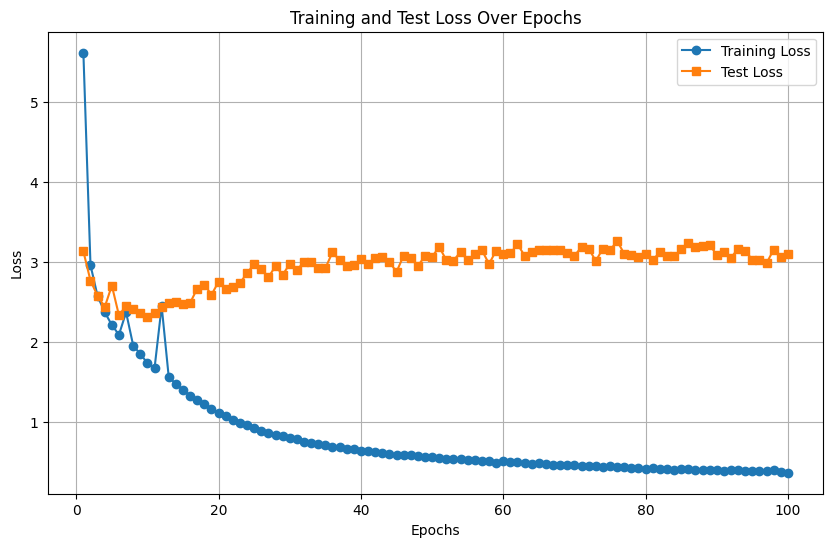

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define LSTM Model
class OptimizedBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(OptimizedBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x.long())
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        dropped_out = self.dropout(last_hidden)
        output = self.fc(dropped_out)
        return output


# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 128
output_dim = 1
num_layers = 3
num_epochs = 100
learning_rate = 0.001
embedding_dim = 100

# Initialize model, loss function, and optimizer
vocab_size = len(vocab) + 1  # Use your vocabulary size
model = OptimizedBiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initialize lists to store training and testing losses
train_losses = []
test_losses = []

# Training Loop
for t in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    batch_num = 0

    # Training phase
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y.float())
        print(f"Epoch {t+1}, Batch {batch_num}/{len(train_loader)}, Training Loss: {loss:.4f}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        epoch_train_loss += loss.item()
        batch_num += 1

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    # Evaluation phase on the test set
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            # Ensure indices are valid for the embedding layer
            batch_X = torch.clamp(batch_X, 0, vocab_size - 1)

            # Ensure shapes match for loss calculation
            batch_Y = batch_Y.view(-1, 1)  # Reshape to [batch_size, 1]

            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_Y.float())
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print epoch progress
    print(f"Epoch {t+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(test_losses)

[3.131572736161096, 2.76469515476908, 2.5756656655243466, 2.4356348301683153, 2.704208961554936, 2.331142951335226, 2.4532586123262132, 2.417185998388699, 2.366822593978473, 2.316369118435042, 2.356951272913388, 2.4379546642303467, 2.4911506537880217, 2.4984587792839323, 2.479176795908383, 2.487879829747336, 2.6668931926999773, 2.7169976936919347, 2.5888824526752745, 2.753108929310526, 2.663636786597116, 2.689198212964194, 2.7378784098795483, 2.857735174042838, 2.9760231993028095, 2.9137066773005893, 2.8085944780281613, 2.9467536679336, 2.838561522109168, 2.9741115335907256, 2.8944475650787354, 3.0023009862218584, 3.0038290343114307, 2.9259183747427806, 2.921163043805531, 3.118866481951305, 3.021870957953589, 2.948903339249747, 2.955783132995878, 3.0299329331942966, 2.9690197152750835, 3.0532357564994266, 3.0621107050350735, 3.001053028873035, 2.8748733741896495, 3.0782326630183627, 3.0475130400487354, 2.9486863293818066, 3.0738810982022966, 3.0654483437538147, 3.1854495917047774, 3.02

Accuracy: 0.7917857142857143
Test MSE: 3.1035478115081787
Test MAE: 1.324675440788269
Test R² Score: 0.4498298764228821
(5600,)
(5600,)


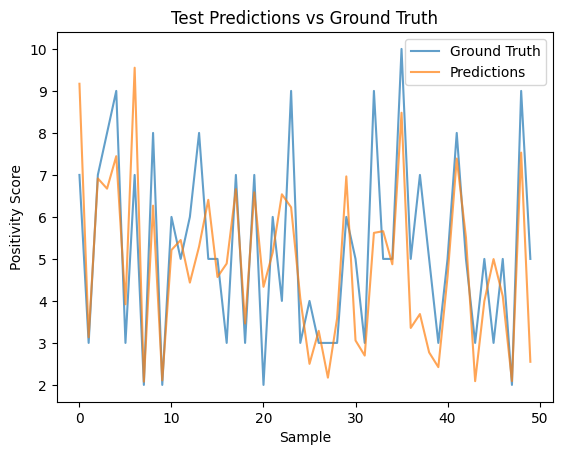

In [ ]:
# Evaluate on Test Data
model.eval()
test_predictions_list = []
test_targets_list = []
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        # Move to the appropriate device
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # Clamp indices in batch_X to ensure they are within the valid range
        batch_X = torch.clamp(batch_X, 0, vocab_size - 1)

        # Forward pass
        test_predictions = model(batch_X)

        # Store predictions and true values
        test_predictions_list.extend(test_predictions.squeeze(-1).cpu().numpy())
        test_targets_list.extend(batch_Y.cpu().numpy())

# Convert predictions and targets directly to NumPy arrays
test_predictions_array = np.array(test_predictions_list)
test_targets_array = np.array(test_targets_list)

# Classify as 0 or 1 based on prediction >= 6.25
binary_targets = []
binary_results = []
for prediction in test_predictions_array:
    if prediction >= 6.25:
        binary_results.append(1)
    else:
        binary_results.append(0)

for target in test_targets_array:
    if target >= 6.25:
        binary_targets.append(1)
    else:
        binary_targets.append(0)

print("Accuracy:", accuracy_score(binary_targets, binary_results))

# Flatten arrays to ensure 1D shape
test_predictions_array = test_predictions_array.flatten()
test_targets_array = test_targets_array.flatten()

# Calculate Mean Squared Error (MSE) for Regression
print(f"Test MSE: {mean_squared_error(test_targets_array, test_predictions_array)}")

# Calculate Mean Absolute Error (MAE)
print(f"Test MAE: {mean_absolute_error(test_targets_array, test_predictions_array)}")

# Calculate R² Score (coefficient of determination)
print(f"Test R² Score: {r2_score(test_targets_array, test_predictions_array)}")


print(test_targets_array.shape)
print(test_predictions_array.shape)

# Plot predictions vs ground truth for test set
plt.plot(range(50), test_targets_array[:50], label="Ground Truth", alpha=0.7)
plt.plot(range(50), test_predictions_array[:50], label="Predictions", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("Positivity Score")
plt.title("Test Predictions vs Ground Truth")
plt.legend()
plt.show()


# OPTIMIZED Bidirectional LSTM - Early Stopping

Epoch 1, Batch 0/224, Training Loss: 37.3850
Epoch 1, Batch 1/224, Training Loss: 33.9407
Epoch 1, Batch 2/224, Training Loss: 36.0776
Epoch 1, Batch 3/224, Training Loss: 34.7021
Epoch 1, Batch 4/224, Training Loss: 31.8019
Epoch 1, Batch 5/224, Training Loss: 30.5979
Epoch 1, Batch 6/224, Training Loss: 31.3441
Epoch 1, Batch 7/224, Training Loss: 28.1005
Epoch 1, Batch 8/224, Training Loss: 20.8916
Epoch 1, Batch 9/224, Training Loss: 16.3903
Epoch 1, Batch 10/224, Training Loss: 16.7016
Epoch 1, Batch 11/224, Training Loss: 10.4258
Epoch 1, Batch 12/224, Training Loss: 7.9010
Epoch 1, Batch 13/224, Training Loss: 6.4749
Epoch 1, Batch 14/224, Training Loss: 6.5724
Epoch 1, Batch 15/224, Training Loss: 5.1949
Epoch 1, Batch 16/224, Training Loss: 6.1513
Epoch 1, Batch 17/224, Training Loss: 6.1317
Epoch 1, Batch 18/224, Training Loss: 5.9137
Epoch 1, Batch 19/224, Training Loss: 6.6338
Epoch 1, Batch 20/224, Training Loss: 4.9809
Epoch 1, Batch 21/224, Training Loss: 6.2237
Epoch 1,

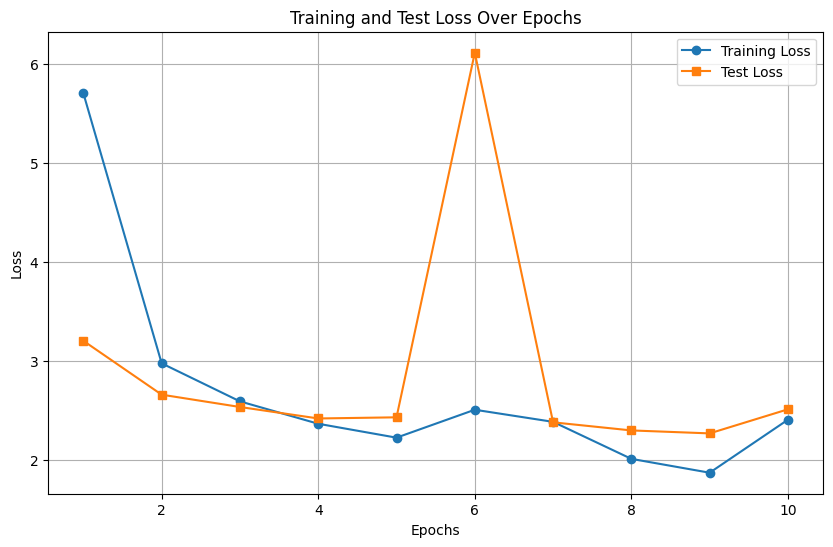

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define LSTM Model
class OptimizedBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(OptimizedBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x.long())
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        dropped_out = self.dropout(last_hidden)
        output = self.fc(dropped_out)
        return output


# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim = 128
output_dim = 1
num_layers = 3
num_epochs = 10
learning_rate = 0.001
embedding_dim = 100

# Initialize model, loss function, and optimizer
vocab_size = len(vocab) + 1  # Use your vocabulary size
model = OptimizedBiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initialize lists to store training and testing losses
train_losses = []
test_losses = []

# Training Loop
for t in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    batch_num = 0

    # Training phase
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y.float())
        print(f"Epoch {t+1}, Batch {batch_num}/{len(train_loader)}, Training Loss: {loss:.4f}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        epoch_train_loss += loss.item()
        batch_num += 1

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    # Evaluation phase on the test set
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in test_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            # Ensure indices are valid for the embedding layer
            batch_X = torch.clamp(batch_X, 0, vocab_size - 1)

            # Ensure shapes match for loss calculation
            batch_Y = batch_Y.view(-1, 1)  # Reshape to [batch_size, 1]

            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_Y.float())
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print epoch progress
    print(f"Epoch {t+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(test_losses) # just a second check
print(test_losses.index(min(test_losses)))

[3.3191971267972673, 2.849556314093726, 2.677961549588612, 2.6936318640198027, 2.4052314311265945, 2.4132461228540967, 2.4769255965948105, 2.4436435784612383, 2.355482952935355, 2.3927909029381618]
8


Accuracy: 0.8176785714285715
Test MSE: 2.513878107070923
Test MAE: 1.2193543910980225
Test R² Score: 0.5543614625930786
(5600,)
(5600,)


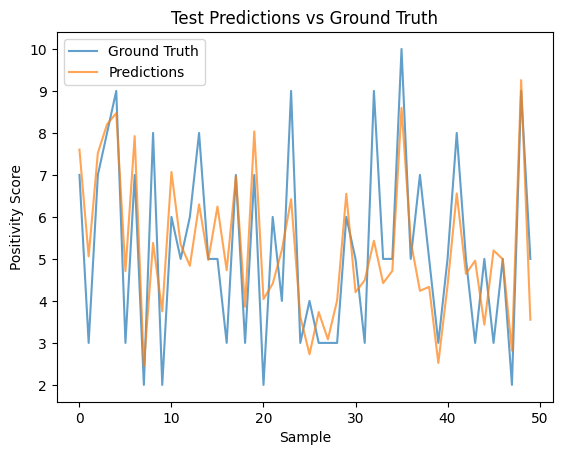

In [ ]:
# Evaluate on Test Data
model.eval()
test_predictions_list = []
test_targets_list = []
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        # Move to the appropriate device
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # Clamp indices in batch_X to ensure they are within the valid range
        batch_X = torch.clamp(batch_X, 0, vocab_size - 1)

        # Forward pass
        test_predictions = model(batch_X)

        # Store predictions and true values
        test_predictions_list.extend(test_predictions.squeeze(-1).cpu().numpy())
        test_targets_list.extend(batch_Y.cpu().numpy())

# Convert predictions and targets directly to NumPy arrays
test_predictions_array = np.array(test_predictions_list)
test_targets_array = np.array(test_targets_list)

# Classify as 0 or 1 based on prediction >= 6.25
binary_targets = []
binary_results = []
for prediction in test_predictions_array:
    if prediction >= 6.25:
        binary_results.append(1)
    else:
        binary_results.append(0)

for target in test_targets_array:
    if target >= 6.25:
        binary_targets.append(1)
    else:
        binary_targets.append(0)

print("Accuracy:", accuracy_score(binary_targets, binary_results))

# Flatten arrays to ensure 1D shape
test_predictions_array = test_predictions_array.flatten()
test_targets_array = test_targets_array.flatten()

# Calculate Mean Squared Error (MSE) for Regression
print(f"Test MSE: {mean_squared_error(test_targets_array, test_predictions_array)}")

# Calculate Mean Absolute Error (MAE)
print(f"Test MAE: {mean_absolute_error(test_targets_array, test_predictions_array)}")

# Calculate R² Score (coefficient of determination)
print(f"Test R² Score: {r2_score(test_targets_array, test_predictions_array)}")


print(test_targets_array.shape)
print(test_predictions_array.shape)

# Plot predictions vs ground truth for test set
plt.plot(range(50), test_targets_array[:50], label="Ground Truth", alpha=0.7)
plt.plot(range(50), test_predictions_array[:50], label="Predictions", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("Positivity Score")
plt.title("Test Predictions vs Ground Truth")
plt.legend()
plt.show()


In [ ]:
# Test random epochs
new_review = "Rude"
# 0.5 Correct any mis-spelling
new_review_corrected = correct_with_symspell(new_review)

# 1. Clean the new review
new_review_cleaned = clean_text(new_review_corrected)

# 2. Convert to numerical representation
new_review_int = [vocab_to_int.get(word, 0) for word in new_review_cleaned]

# 3. Pad the review
new_review_padded = [0]*(max_len - len(new_review_int)) + new_review_int

# 4. Convert to tensor
new_review_tensor = torch.Tensor(new_review_padded).long().unsqueeze(0).to(device) # unsqueeze to add batch dimension

# 5. Make prediction
with torch.no_grad():
  new_review_prediction = model(new_review_tensor)

# 6. Print the prediction
print(new_review_prediction.item())

4.339258193969727
